# Learn To Synchronize Videos

## Model declaration

In [20]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import sync_net
reload(sync_net)
from sync_net import reset_first_and_last_layers, TripletNet, TripletLoss
from data_loader import get_datasets, get_test_set
from trainer import fit
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
reset_first_and_last_layers(embedding_net)
model = TripletNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin=0.5)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\base"

## Load dataset

In [ ]:
training_path = r'\\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie'
validation_path = r'\\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

## Load training state

In [3]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\base\training_state_0.pth


## Train

In [7]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path)

## Test trained model

In [4]:
load_state_path = save_path + r"\training_state_3.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\base\training_state_3.pth


DataParallel(
  (module): TripletNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [5]:
test_path = r'\\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie'
test_set = get_test_set(test_path)

105 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\LCA_AP
79 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\LCA_LAT
121 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\RCA_AP
113 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\AA-4\export\RCA_LAT
75 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in \\primnis.gi.polymtl.ca\dfs\cheriet\Images\Cardiologie\Angiographie\ABL-5\export\LCA_30RAO
85 vali

Batch 1/56 with 103 sequences


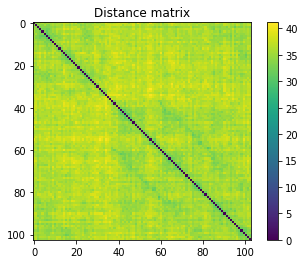

Batch 2/56 with 108 sequences


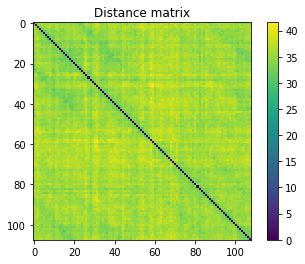

Batch 3/56 with 102 sequences


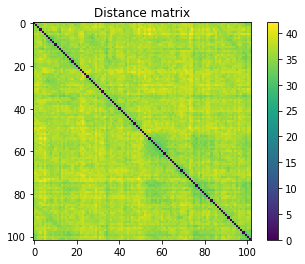

Batch 4/56 with 76 sequences


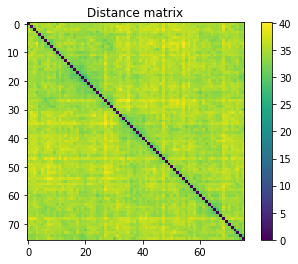

Batch 5/56 with 77 sequences


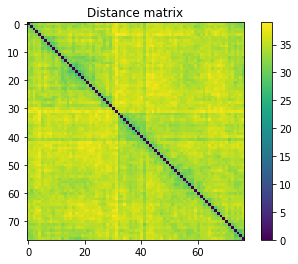

Batch 6/56 with 119 sequences


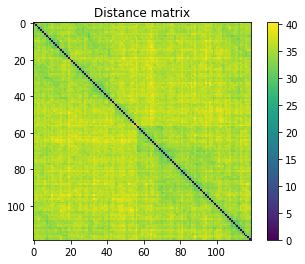

Batch 7/56 with 111 sequences


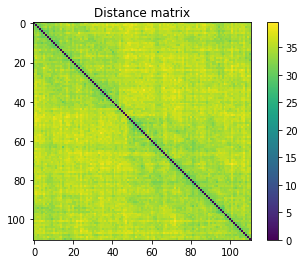

Batch 8/56 with 73 sequences


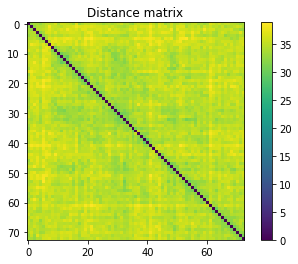

Batch 9/56 with 76 sequences


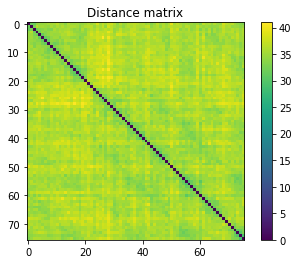

Batch 10/56 with 83 sequences


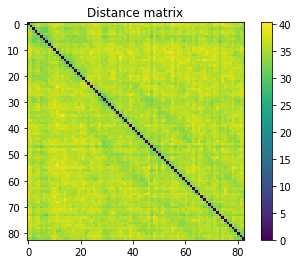

Batch 11/56 with 83 sequences


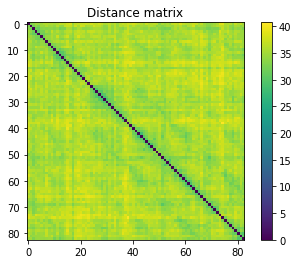

Batch 12/56 with 37 sequences


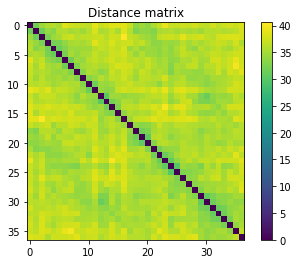

Batch 13/56 with 37 sequences


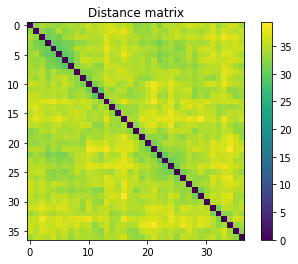

Batch 14/56 with 46 sequences


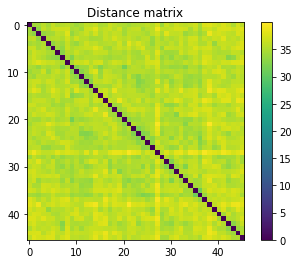

Batch 15/56 with 42 sequences


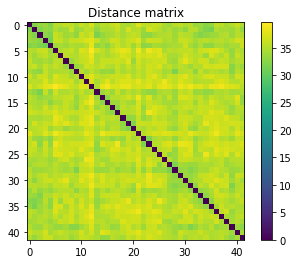

Batch 16/56 with 47 sequences


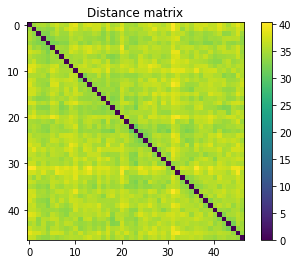

Batch 17/56 with 49 sequences


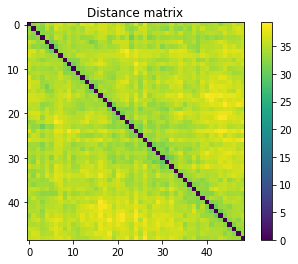

Batch 18/56 with 52 sequences


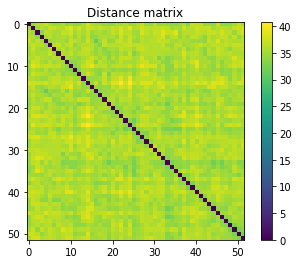

Batch 19/56 with 58 sequences


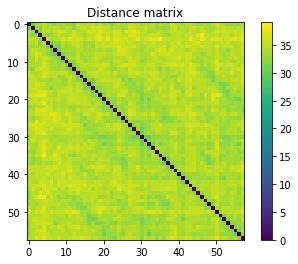

Batch 20/56 with 49 sequences


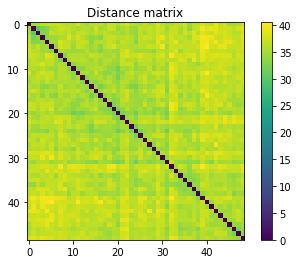

Batch 21/56 with 44 sequences


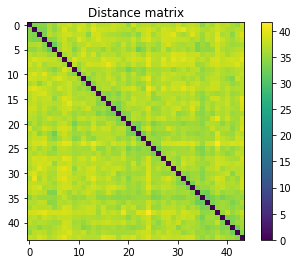

Batch 22/56 with 46 sequences


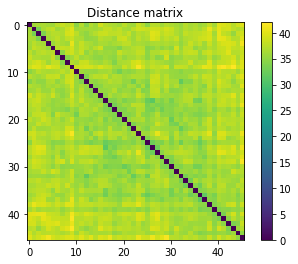

Batch 23/56 with 47 sequences


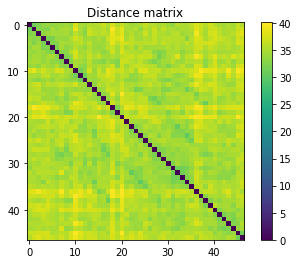

Batch 24/56 with 60 sequences


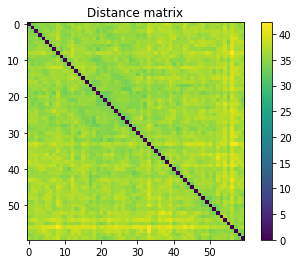

Batch 25/56 with 51 sequences


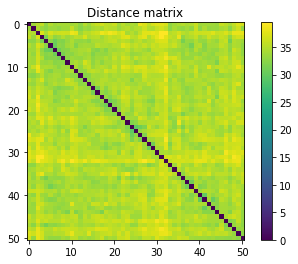

Batch 26/56 with 43 sequences


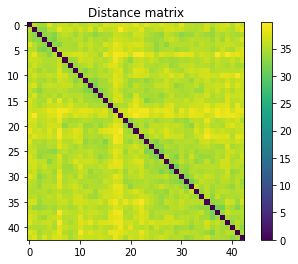

Batch 27/56 with 29 sequences


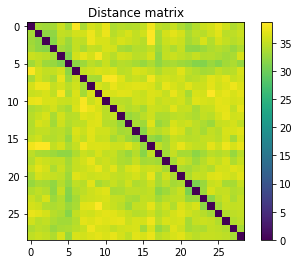

Batch 28/56 with 68 sequences


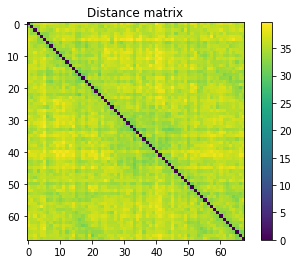

Batch 29/56 with 63 sequences


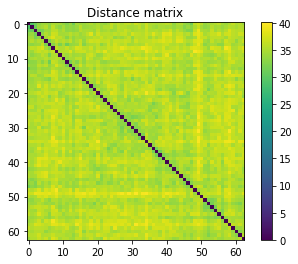

Batch 30/56 with 42 sequences


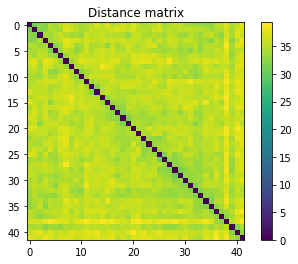

Batch 31/56 with 82 sequences


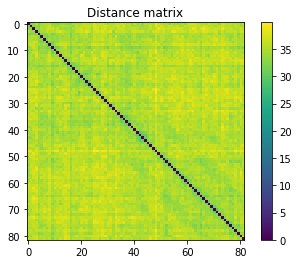

Batch 32/56 with 97 sequences


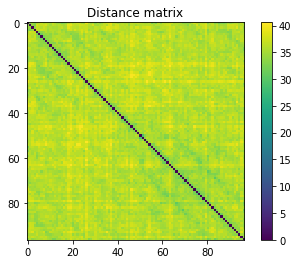

Batch 33/56 with 80 sequences


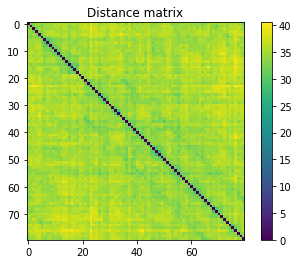

Batch 34/56 with 73 sequences


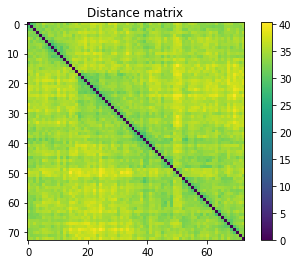

Batch 35/56 with 92 sequences


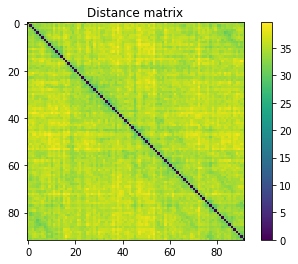

Batch 36/56 with 105 sequences


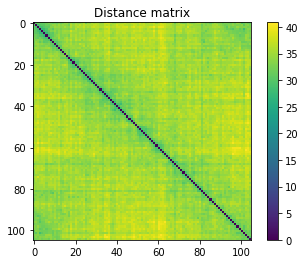

Batch 37/56 with 37 sequences


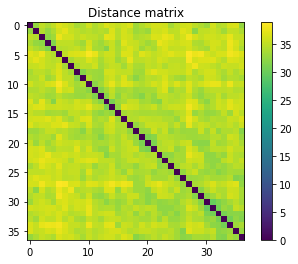

Batch 38/56 with 40 sequences


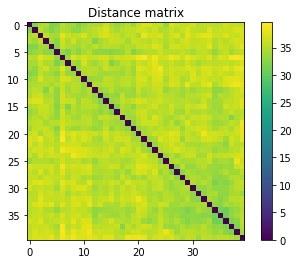

Batch 39/56 with 39 sequences


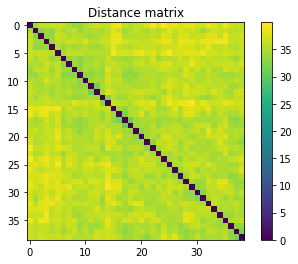

Batch 40/56 with 48 sequences


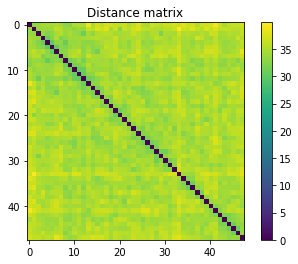

Batch 41/56 with 43 sequences


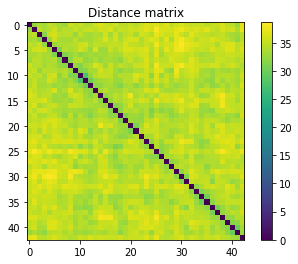

Batch 42/56 with 61 sequences


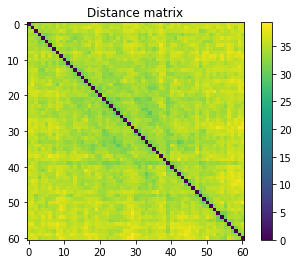

Batch 43/56 with 74 sequences


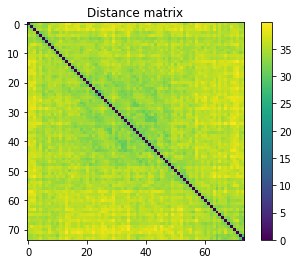

Batch 44/56 with 48 sequences


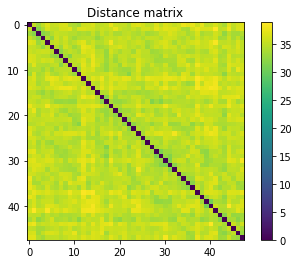

Batch 45/56 with 45 sequences


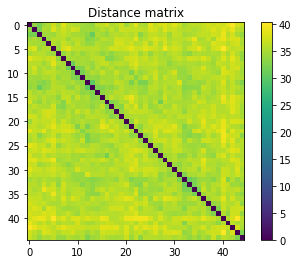

Batch 46/56 with 39 sequences


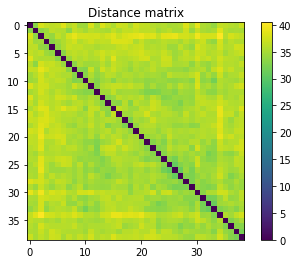

Batch 47/56 with 39 sequences


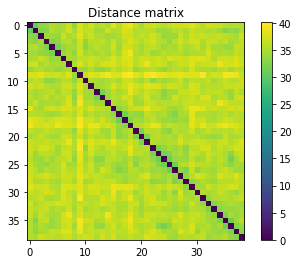

Batch 48/56 with 50 sequences


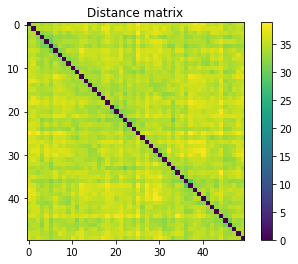

Batch 49/56 with 53 sequences


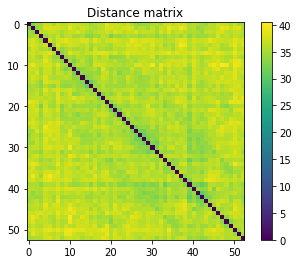

Batch 50/56 with 49 sequences


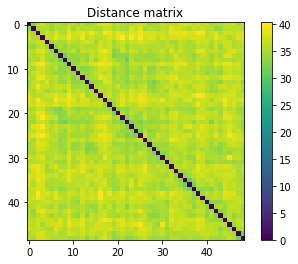

Batch 51/56 with 49 sequences


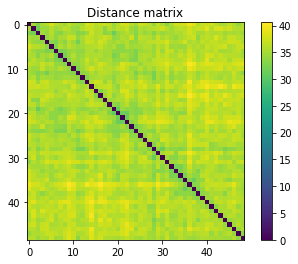

Batch 52/56 with 50 sequences


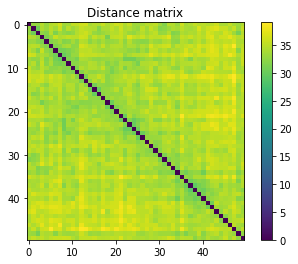

Batch 53/56 with 44 sequences


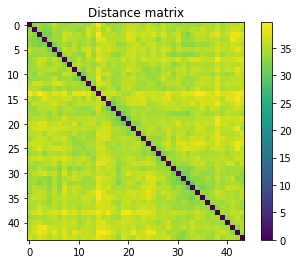

Batch 54/56 with 50 sequences


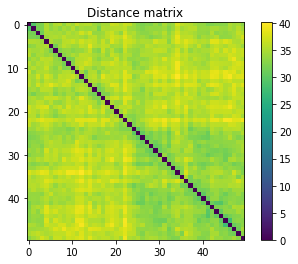

Batch 55/56 with 41 sequences


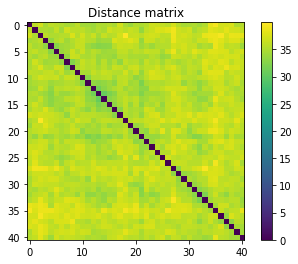

Batch 56/56 with 39 sequences


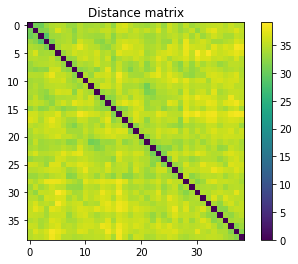

In [28]:
def calc_distance_matrix(embeddings):
    distances = []
    for i in range(len(embeddings)):
        distances_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
            elif j == i:
                distances_i.append(0)
            else:
                val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(val.cpu().numpy())
        distances.append(distances_i)
    distances = np.array(distances)
    return distances

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    for batch_index, sequences in enumerate(test_loader):
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} with {len(sequences[0])} sequences")
        for i in range(len(sequences[0])):
            sequence = sequences[:, i]
            embedding = model(sequence) # (1, 1000)
            embeddings.append(embedding)
        distance_matrix = calc_distance_matrix(embeddings)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title("Distance matrix")
        plt.show()